In [3]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files, ttprint
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
import rasterio
import pyproj
from shapely.geometry import Point
from eumap.mapper import LandMapper
from scipy.special import expit, logit

import warnings

import matplotlib
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

import joblib
import pickle

from benchmark_pipeline import read_features, run_cumusort, parameter_fine_tuning, evaluate_model, calc_ccc, separate_data
# covs_all = read_features(f'/home/opengeohub/xuemeng/work_xuemeng/soc/SOC-EU/features/001_covar_all.txt')
ccc_scorer = make_scorer(calc_ccc, greater_is_better=True)

# df = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/data/002.2_data_whole.csv')

prop_list = ['ocd','oc','bulk_density'] 
space_list = ['log1p','log1p','normal'] # 
filt_list = [5,5,5] 

### Producing metrics for different covs

In [10]:
results = []
for ii in [0]:#range(len(prop_list)):
    print(f'processing {prop_list[ii]}')
    prop = prop_list[ii]
    space = space_list[ii]
    output_folder = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}'
    
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    else:
        tgt = prop
    
    # features
    covs_dyn = read_features(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs_{prop}.txt')
    covs_rfecv = read_features(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs.rfecv_{prop}.txt')
    covs_both = [covs_dyn, covs_rfecv]
    
    # # separate al, train and test data
    cal = pd.read_csv(f'{output_folder}/benchmark_cal.pnts_{prop}.csv',low_memory=False)
    cal = cal.dropna(subset=[tgt]+covs_dyn+covs_rfecv)
    
    # models, only test rf
    rf = RandomForestRegressor(random_state=60, n_jobs=-1) # default

    # evaluate
    cv = GroupKFold(n_splits=5)
    covs_name = ['dynamic','rfecv']
    for icov in [0,1]:
        covs = covs_both[icov]
        name_cov = covs_name[icov]
        
        ttprint(f'cross val predict {prop}, in {space} space')
        y_cv = cross_val_predict(rf, cal[covs], cal[tgt], cv=cv, groups=cal['tile_id'], n_jobs=90)

        # ttprint(f'validation on test data for {prop}, in {space} space')
        # rf.fit(train[covs], train[tgt])
        # y_val = rf.predict(test[covs])
        
        # MAE is reported in original scale, while R2 and CCC are reported in log1p scale
        results.append({
            'property': prop,
            'covs':name_cov,
            'MAE_cv': mean_absolute_error(cal[prop],np.expm1(y_cv)),
            'MedAE_cv': median_absolute_error(cal[prop],np.expm1(y_cv)),
            # 'MAE_val': mean_absolute_error(test[prop],np.expm1(y_val)),
            'MAPE_cv': mean_absolute_percentage_error(cal[prop],np.expm1(y_cv)),
            # 'MAPE_val': mean_absolute_percentage_error(test[prop],np.expm1(y_val)),
            'R2_cv': r2_score(cal[prop],np.expm1(y_cv)),
            'R2_log': r2_score(cal[tgt],y_cv),
            'CCC_cv': calc_ccc(cal[prop],np.expm1(y_cv)),
            'CCC_log': calc_ccc(cal[tgt],y_cv),
            'feat_num': len(covs)
        })

processing ocd
[08:33:50] cross val predict ocd, in log1p space
[08:33:53] cross val predict ocd, in log1p space


In [11]:
results = pd.DataFrame(results)
results['time (min)'] = [1.96, 13.70]
results

,property,covs,MAE_cv,MedAE_cv,MAPE_cv,R2_cv,R2_log,CCC_cv,CCC_log,feat_num,time (min)
0,ocd,dynamic,8.618275,4.422062,0.547234,0.469658,0.707895,0.629172,0.825508,55,1.96
1,ocd,rfecv,8.612851,4.365939,0.552853,0.469047,0.704439,0.626245,0.822387,69,13.70


In [52]:
a = []
for i in covs_dyn:
    if i not in covs_rfecv:
        a.append(i)
        
a

['bioclim.var_chelsa.bio5_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822.tif',
 'bioclim.var_chelsa.bio18_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822.tif',
 'geomorphon.bareearth_ensemble_m_240m_s_20000101_20221231_eu_epsg.3035_v20240501.tif',
 'bioclim.var_chelsa.bio8_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822.tif',
 'sfcWind.max_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531.tif',
 'clt.range_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531.tif',
 'lst_mod11a2.nighttime_p95_1km_s_{year}0701_{year}0731_eu_epsg.3035_v20240531.tif',
 'lst_mod11a2.nighttime_p50_1km_s_{year}0801_{year}0831_eu_epsg.3035_v20240531.tif']

In [51]:
a = []
for i in covs_rfecv:
    if i not in covs_dyn:
        a.append(i)
        
a

['wv_mcd19a2v061.seasconv_m_1km_s_{year}0201_{year}0228_eu_epsg.3035_v20230619.tif',
 'nir_glad.landsat.ard2.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
 'accum.precipitation_chelsa.montlhy_m_1km_s_{year}0201_{year}0228_eu_epsg.3035_v20240531.tif',
 'accum.precipitation_chelsa.montlhy_m_1km_s_{year}0901_{year}0930_eu_epsg.3035_v20240531.tif',
 'accum.precipitation_chelsa.annual_m_1km_s_{year}0101_{year}1231_eu_epsg.3035_v20240531.tif',
 'lst_mod11a2.nighttime_p95_1km_s_{year}0501_{year}0531_eu_epsg.3035_v20240531.tif',
 'lst_mod11a2.nighttime_p95_1km_s_{year}1001_{year}1031_eu_epsg.3035_v20240531.tif',
 'lst_mod11a2.daytime_sd_1km_s_{year}0101_{year}0131_eu_epsg.3035_v20240531.tif',
 'lst_mod11a2.daytime_p95_1km_s_{year}0101_{year}0131_eu_epsg.3035_v20240531.tif',
 'lst_mod11a2.daytime_p95_1km_s_{year}0501_{year}0531_eu_epsg.3035_v20240531.tif',
 'lst_mod11a2.daytime_sd_1km_s_{year}0201_{year}0228_eu_epsg.3035_v20240531.tif',
 'lst_mod11a2.daytime_p95_1km

In [12]:
results.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/metrics_feature.selection_methods.compare.csv',index=False)

### Feature selection with RFECV

processing ocd


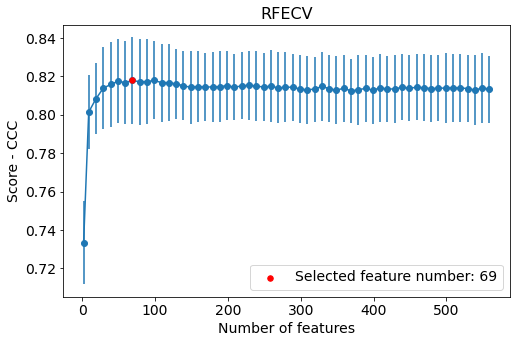

rfecv used 13.704781365394592 mins


In [2]:
# a function to determine optimal number of features
from sklearn.model_selection import GroupKFold, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV, RFE
from scipy.signal import argrelmin, argrelmax
import joblib
import random
import multiprocessing

covs_all = read_features(f'/home/opengeohub/xuemeng/work_xuemeng/soc/SOC-EU/features/001_covar_all.txt')

for ii in [0]:#range(len(prop_list)):
    print(f'processing {prop_list[ii]}')
    prop = prop_list[ii]
    space = space_list[ii]
    output_folder = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}'
    
    cv = GroupKFold(n_splits=5)
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    else:
        tgt = prop
    
    # # separate al, train and test data
    cal = pd.read_csv(f'{output_folder}/benchmark_cal.pnts_{prop}.csv',low_memory=False)
    cal = cal.dropna(subset=[tgt]+covs_all, how='any')
    rf = RandomForestRegressor(random_state=41, n_jobs=-1, n_estimators=100) # default
    rfecv = RFECV(rf, cv=cv, step=10, min_features_to_select= 2, n_jobs=2, scoring=ccc_scorer, verbose=0)
    start = time.time()
    rfecv.fit(cal[covs_all], cal[tgt], groups=cal['tile_id'])
    end = time.time()
    time_rfecv = (end-start)/60
    
    # Plotting the RFECV results
    num_features = np.arange(len(covs_all),2,-10)
    num_features = num_features[::-1]
    num_features = np.insert(num_features, 0, 2)
    plt.figure(figsize=(8, 5))
    plt.errorbar(
        x=num_features,
        y=rfecv.cv_results_['mean_test_score'],
        yerr=rfecv.cv_results_["std_test_score"],
        fmt='-o'
    )
    # plt.axvline(x=rfecv.n_features_, color='red', linestyle='--')
    a = np.argmax(rfecv.cv_results_['mean_test_score'])
    plt.scatter(rfecv.n_features_, max(rfecv.cv_results_['mean_test_score']), color='red', s=30, zorder=5,label=f'Selected feature number: {rfecv.n_features_}')
    plt.xlabel('Number of features', fontsize=14)
    plt.ylabel('Score - CCC', fontsize=14)
    plt.title('RFECV', fontsize=16)
    plt.legend(loc='lower right',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/ocd/plot_feature.elimination.rfecv_ocd.pdf', dpi=300, bbox_inches='tight')
    plt.show()

    # save features
    selected_features = np.array(covs_all)[rfecv.support_]
    with open(f'{output_folder}/benchmark_selected.covs.rfecv_{prop}.txt', 'w') as file:
        for item in selected_features:
            file.write(f"{item}\n")

    print(f'rfecv used {time_rfecv} mins')

In [59]:
num_features[a]

44

In [60]:
rfecv.n_features_

44

In [50]:
rfecv.cv_results_['mean_test_score']

array([0.68586862, 0.74714609, 0.77520838, 0.78161008, 0.78561457,
       0.78814567, 0.78658663, 0.78585493, 0.78675436, 0.78570395,
       0.78529806, 0.78434957, 0.78411766, 0.78422785, 0.78521147,
       0.78501827, 0.78544153, 0.78404355, 0.78407859, 0.7842215 ,
       0.78338482, 0.78323601, 0.78273683, 0.78303717, 0.78302047,
       0.78287813, 0.78366985, 0.78437453, 0.78347205, 0.78374523,
       0.78376618, 0.78362378, 0.78346847, 0.78344539, 0.78443277,
       0.78273135, 0.78344062, 0.78359821, 0.78405465, 0.7830628 ,
       0.78434418, 0.78304503, 0.7831934 , 0.78358349, 0.78340229,
       0.78338521, 0.78338548, 0.78359202, 0.78372514, 0.78380082,
       0.78337593, 0.78312727, 0.78377075, 0.78333711, 0.78323361])

In [9]:
prop = 'ocd'
dff = df.loc[df[prop].notna()]
dff = dff.loc[dff[f'{prop}_qa']>5]

In [11]:
dff.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd.feat.csv',index=False)

In [ ]:
dff = dff

In [13]:
dff = dff[['id', 'lat', 'lon', 'time', 'ref', 'nuts0','hzn_dep', 'texture1', 'texture2',
       'texture1_qa', 'texture2_qa', 'ocd', 'ocd_qa']]
dff.to_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/data_ocd.no.feat.csv',index=False)

### plot of RSCFI

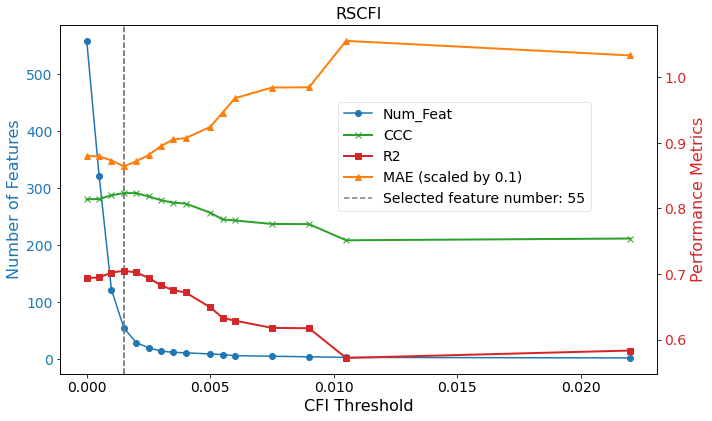

In [15]:
results_df = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/ocd/metrics.rank_feature.elimination_ocd.csv')
    
        
results_df = results_df.sort_values(by='Threshold')
# plot feature elimination analysis
fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:blue'
ax1.set_xlabel('CFI Threshold', fontsize=16)
ax1.set_ylabel('Number of Features', color=color, fontsize=16)
line1 = ax1.plot(results_df['Threshold'], results_df['Num_Features'], color=color, marker='o', label='Num_Feat')
ax1.tick_params(axis='y', labelcolor=color, labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Performance Metrics', color=color, fontsize=16)
line2 = ax2.plot(results_df['Threshold'], results_df['CCC'], color='tab:green', marker='x', linestyle='-', linewidth=2, label='CCC')
line3 = ax2.plot(results_df['Threshold'], results_df['R2'], color='tab:red', marker='s', linestyle='-', linewidth=2, label='R2')
line4 = ax2.plot(results_df['Threshold'], results_df['MAE']/10, color='tab:orange', marker='^', linestyle='-', linewidth=2, label='MAE (scaled by 0.1)')
# line5 = ax2.plot(results_df['Threshold'], results_df['MAPE'], color='tab:purple', marker='d', linestyle='-', linewidth=2, label='MAPE')

ax2.tick_params(axis='y', labelcolor=color, labelsize=14)

fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid cutting off the title

# Combine legends
lines = line1 + line2 + line3 + line4 #+ line5
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.15, 0.95), fontsize=14, framealpha=0.5)

# Best combined rank
best_combined_rank_index = results_df['Combined_Rank'].idxmin()
best_threshold = results_df.loc[best_combined_rank_index, 'Threshold']
best_num_features = results_df.loc[best_combined_rank_index, 'Num_Features']

# Vertical line for the best and selected threshold
ax1.axvline(x=best_threshold, color='grey', linestyle='--')
# ax1.axvline(x=selected_threshold, color='cyan', linestyle='--', label='Selected Threshold')

# Update the legend to include the vertical line label
lines += [ax1.axvline(x=best_threshold, color='grey', linestyle='--')]
labels += [f'Selected feature number: {best_num_features}']
# lines += [ax1.axvline(x=selected_threshold, color='cyan', linestyle='--')]
# labels += ['Selected Threshold']
ax1.legend(lines, labels, bbox_to_anchor=(0.9,0.8), fontsize=14, framealpha=0.5)#, bbox_to_anchor=(0.15, 0.95)

plt.title(f'RSCFI', fontsize=16)
plt.savefig(f'{output_folder}/plot_feature.elimination_{prop}.pdf', dpi = 300)
plt.show()